### **[캐글 필사]**: Simple Exploration Notebook-Instacart

> 새로운 전처리/시각화를 1가지 이상 적용                 
 - 상관관계 히트맵 시각화 두개(파란색): 시간별/날짜별/날짜간격별 상관관계, 장바구니 추가 순서와 재구매 비율 상관관계 히트맵
 - Department 별 재주문 비율 파이차트로 시각화

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()  #color=color[0]으로 색 지정 가능

%matplotlib inline

pd.options.mode.chained_assignment = None # default='warn'

- 데이터 로드, 살펴보기

In [32]:
order_products_train_df = pd.read_csv("/content/drive/MyDrive/ESAA/과제/order_products__train.csv")
order_products_prior_df = pd.read_csv("/content/drive/MyDrive/ESAA/과제/order_products__prior.csv")
orders_df = pd.read_csv("/content/drive/MyDrive/ESAA/과제/orders.csv")
products_df = pd.read_csv("/content/drive/MyDrive/ESAA/과제/products.csv")
aisles_df = pd.read_csv("/content/drive/MyDrive/ESAA/과제/aisles.csv")
departments_df = pd.read_csv("/content/drive/MyDrive/ESAA/과제/departments.csv")

In [33]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [34]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [35]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


- 행의 개수 비교해 살펴보기        
  - order_products_prior, train 데이터는 마지막 주문 데이터를 따로 학습/테스트 데이터로 나눈 것이므로 데이터 value 수가 적음

In [36]:
# 각각 데이터 셋의 행의 개수들(즉 value 개수)
orders_df.eval_set.value_counts().values

array([3214874,  131209,   75000])

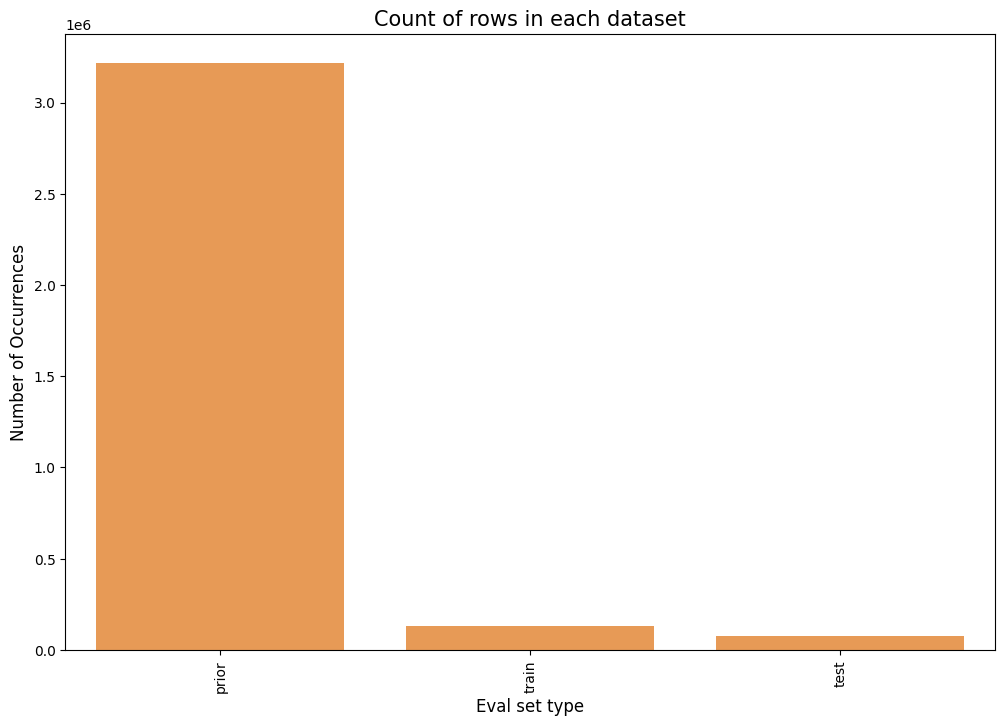

In [37]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [38]:
# 각 데이터셋별로 user_id의 unique값 개수 세기
def get_unique_count(x):
  return len(np.unique(x))

# aggregate 사용해 만든 함수를 적용할 수 있다
cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

,user_id
eval_set,
prior,206209
test,75000
train,131209


- 주문 건수 빈도 barplot
              x=주문수, y=건수         
              x축 범위로 주문 건수가 4~100 사이라는 것을 알 수 있음

In [39]:
cnt_srs=orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs
#cnt_srs.order_number.value_counts()

<ipython-input-39-2e411035d0c4>:1: FutureWarning: The provided callable <function max at 0x7c127450f9a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs=orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()


,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5
...,...,...
206204,206205,4
206205,206206,68
206206,206207,17
206207,206208,50


<ipython-input-40-8c33db6577cc>:2: FutureWarning: The provided callable <function max at 0x7c127450f9a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs=orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()


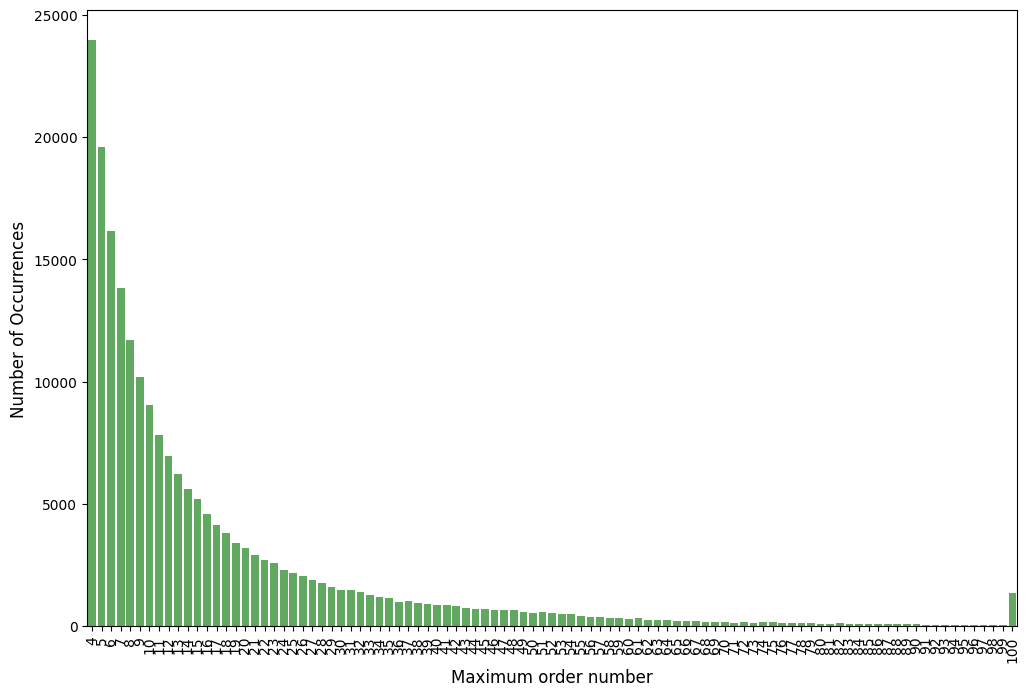

In [40]:
# 유저 별 주문 건수 df로 만든 후 value_counts로 주문 건수 counts하기
cnt_srs=orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

# barplot 생성
plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

- 요일 별 주문 빈도 살펴보기
       가장 많은 주문이 있는 0,1은 주말임을 유추 가능-> 가장 적은 4는 수요일일것

In [41]:
orders_df['order_dow'].unique() # 월~금이 숫자로 표현되어 있음

array([2, 3, 4, 1, 5, 0, 6])

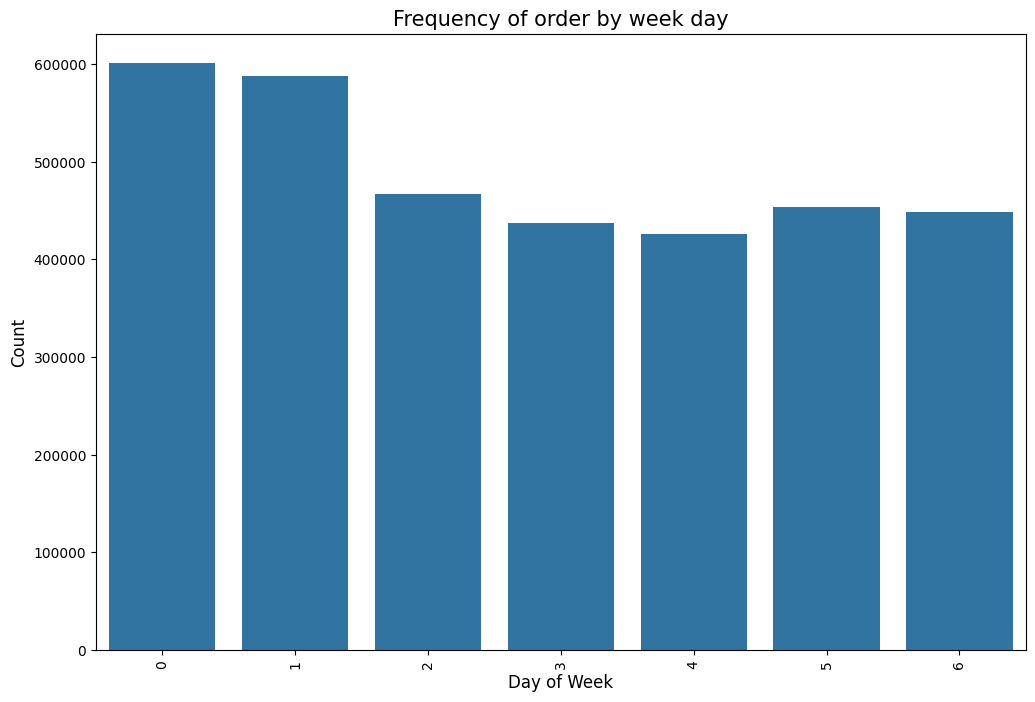

In [42]:
# ordering habit changes with day of week
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow",data=orders_df, color=color[0]) # x='칼럼명', y=자동으로 빈도
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

- 하루 시간대 별 주문 빈도 살펴보기
 - 9-16시가 가장 많음


In [43]:
orders_df['order_hour_of_day'].unique() # 0~23

array([ 8,  7, 12, 15,  9, 14, 16, 11, 10, 19, 18, 17, 13, 20,  0, 21, 22,
        5, 23,  4,  6,  1,  2,  3])

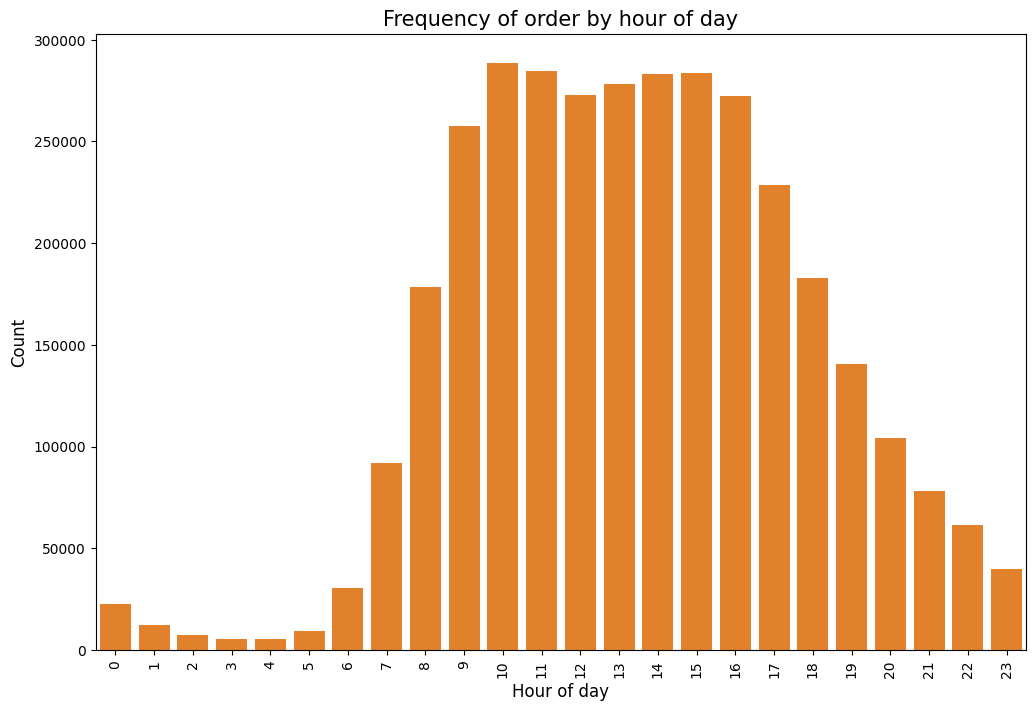

In [44]:
# how the distribution is with respect to time of the day
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')  # rotation=90 == rotation='vertical'
plt.title('Frequency of order by hour of day', fontsize=15)
plt.show()

- 요일과 시간별 주문 건수를 heatmap으로 확인
 - groupby, aggregate(count), reset_index,
 - df.pivot(행, 열, 데이터값)> 요일별, 시간별 데이터 건수를 한번에 확인 가능, heatmap으로 시각화 유용

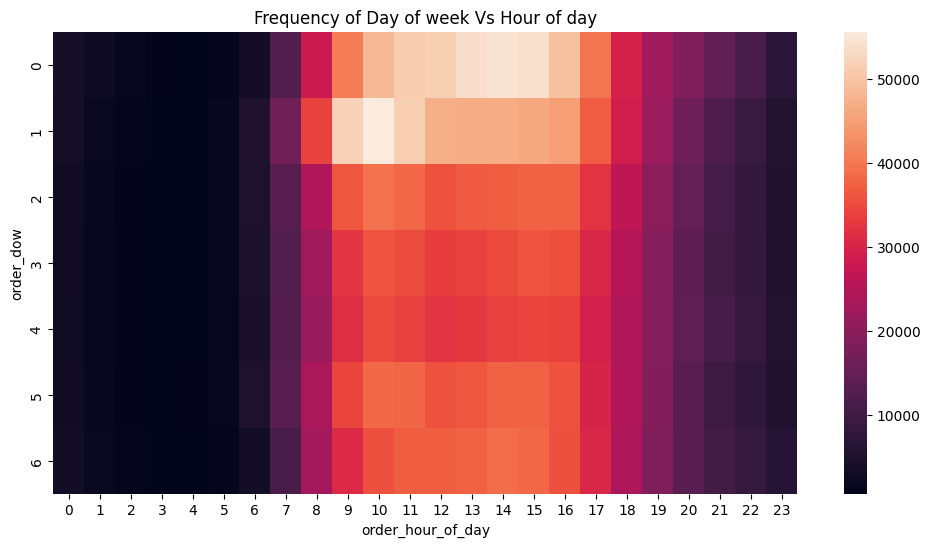

In [45]:
# combine the day of week and hour of day to see the distribution.
grouped_df=orders_df.groupby(['order_dow','order_hour_of_day'])["order_number"].aggregate("count").reset_index()
grouped_df=grouped_df.pivot(index='order_dow', columns='order_hour_of_day',values='order_number') # df.pivot(index='',columns='',values='')
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title('Frequency of Day of week Vs Hour of day')
plt.show()

- 시간별/날짜별/날짜간격별 상관관계를 구하고 heatmap으로 시각화하기 (새로운 시각화)
 - 주문을 오랜만에 하는 것과 주문을 한 시간, 요일은 큰 상관이 없음을 알 수 있다. 그래도 주문시간보다는 요일과 더 큰 상관을 보이며, 주문한 시간과 주문 요일 간에도 상관이 없어 보인다.

In [46]:
corr_week_hour_interval=orders_df[['order_dow', 'order_hour_of_day', 'days_since_prior_order']].corr()
corr_week_hour_interval

,order_dow,order_hour_of_day,days_since_prior_order
order_dow,1.000000,0.005978,-0.028107
order_hour_of_day,0.005978,1.000000,0.001291
days_since_prior_order,-0.028107,0.001291,1.000000


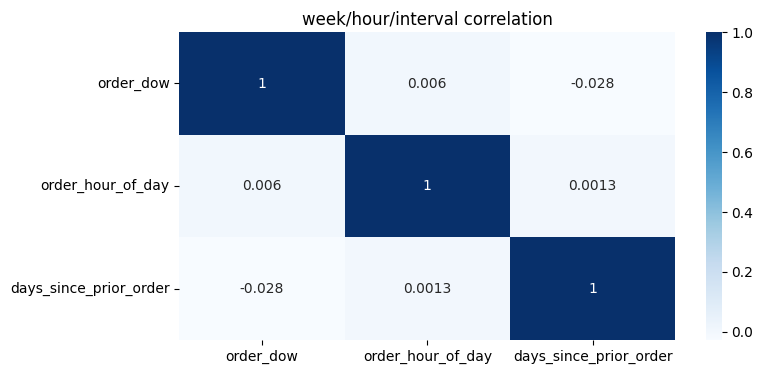

In [96]:
plt.figure(figsize=(8,4))
sns.heatmap(corr_week_hour_interval, annot=True, cmap='Blues')
plt.title("week/hour/interval correlation")
plt.show()

- 주문 날짜 간격 별 건수
 - 일주일에 한번, 월에 한번 주문하는 경우가 가장 많음

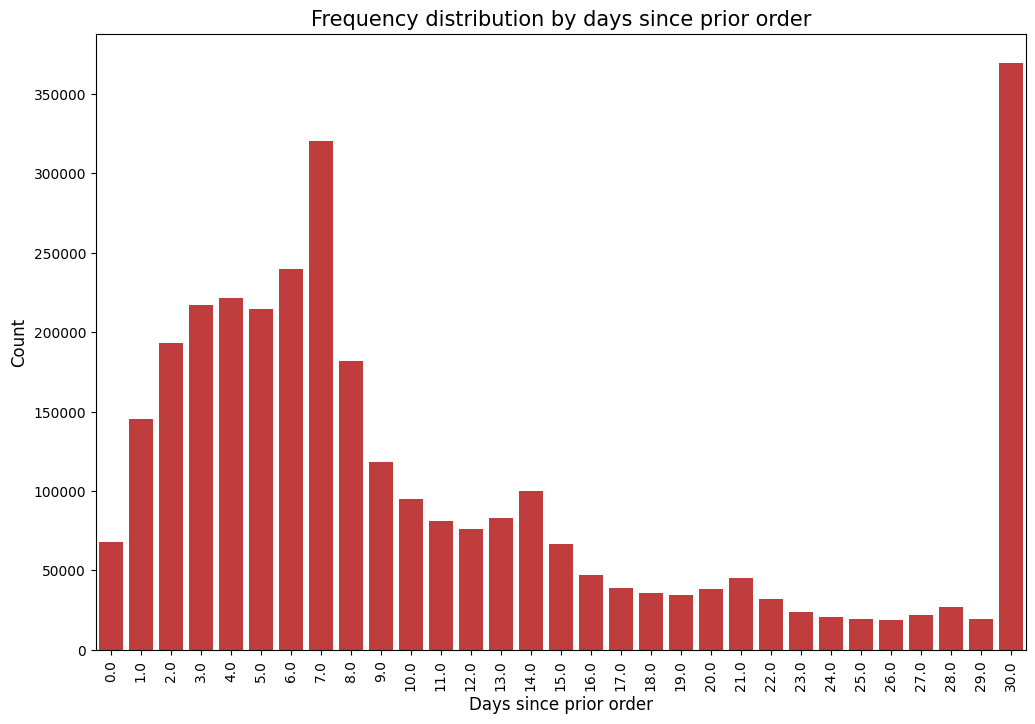

In [48]:
# the time interval between the orders
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count',fontsize=12)
plt.xlabel('Days since prior order',fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

- 재주문 비율 살펴보기

대약 59%의 주문이 재주문 제품

In [49]:
# percentage of re-orders in prior set
# 재주문건수 합 / 전체 건수(=행의 개수)
order_products_prior_df.reordered.sum()/order_products_prior_df.shape[0]

0.5896974667922161

In [50]:
# percentage of re-orders in train set
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

- 재주문하지 않은 제품들:
 - prior데이터에서는 12%의 주문이 재주문0이고, train데이터에서는 6%가 재주문 0이다.
 - 각 고유값의 비율을 알고 싶을 땐 .value_counts()/.shape[0]

In [51]:
order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum") #주문건별 재주문 건수들을 합함

,reordered
order_id,
2,6
3,8
4,12
5,21
6,0
...,...
3421079,0
3421080,4
3421081,0


In [52]:
grouped_df=order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df['reordered'].loc[grouped_df['reordered']>1]=1  # 재주문건수가 1개 이상이면 1로 지정(이산)
grouped_df.reordered.value_counts()/grouped_df.shape[0] # 재주문이 1개이상인 주문과 0개인 주문의 비율 계산

,count
reordered,
1,0.879151
0,0.120849


In [53]:
grouped_df=order_products_train_df.groupby("order_id")['reordered'].aggregate("sum").reset_index()
grouped_df['reordered'].loc[grouped_df['reordered']>1]=1
grouped_df.reordered.value_counts()/grouped_df.shape[0]

,count
reordered,
1,0.93444
0,0.06556


- 각 주문에서 주문한 제품 수 count

In [54]:
order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()

,order_id,add_to_cart_order
0,1,8
1,36,8
2,38,9
3,96,7
4,98,49
...,...,...
131204,3421049,6
131205,3421056,5
131206,3421058,8
131207,3421063,4


In [57]:
grouped_df

,order_id,reordered
0,1,1
1,36,1
2,38,1
3,96,1
4,98,1
...,...,...
131204,3421049,1
131205,3421056,1
131206,3421058,1
131207,3421063,1


In [59]:
grouped_df['add_to_cart_order'].value_counts()

,count
add_to_cart_order,
5,8895
6,8708
7,8541
4,8218
3,8033
...,...
74,2
80,2
75,1


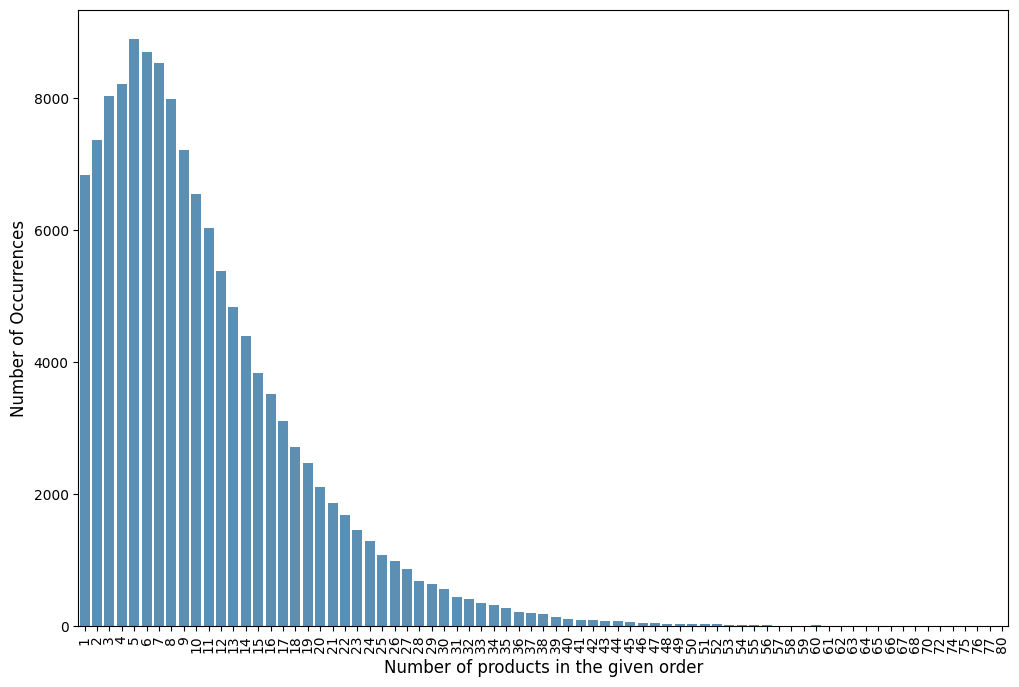

In [58]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index() # 주문별, 제품 총 개수 max로 파악
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

- product_df, aisles_df, departments_df 데이터 살펴보기(제품 디테일)

In [60]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [61]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [62]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


- order_products_prior 파일에 세 파일 merge 하기
 - pd.merge(df1, df2, on='공통칼럼', how='오/왼')

In [63]:
order_products_prior_df=pd.merge(order_products_prior_df, products_df, on='product_id', how='left') # product_name	aisle_id	department_id 추가
order_products_prior_df=pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left') # aisle 추가
order_products_prior_df=pd.merge(order_products_prior_df, departments_df, on='department_id', how='left') # department 추가
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


-  가장 많이 주문 된 제품 20개만 뽑아 살펴보기
 - organic(유기농), 과일이 많음



In [64]:
cnt_srs=order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns=['product_name','frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


- 많이 주문된 aisle 알아보기
 - value_counts().head()

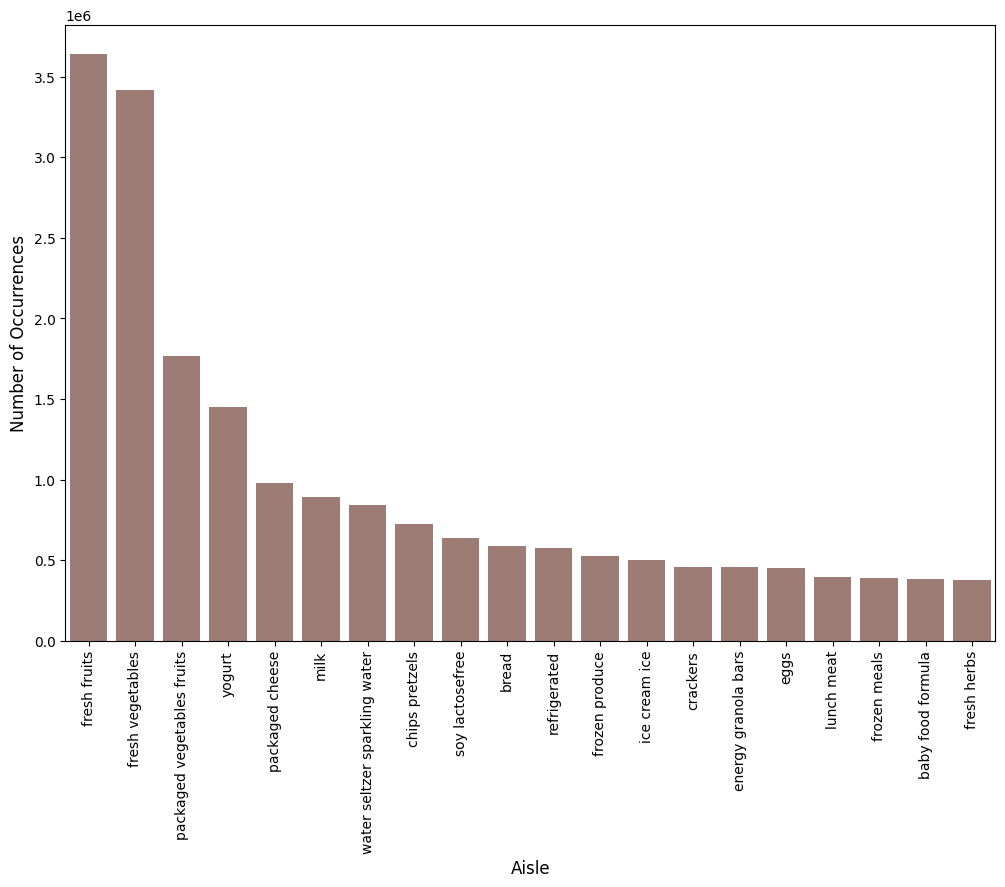

In [65]:
cnt_srs=order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences',fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

- department 빈도 순으로 파이차트 시각화

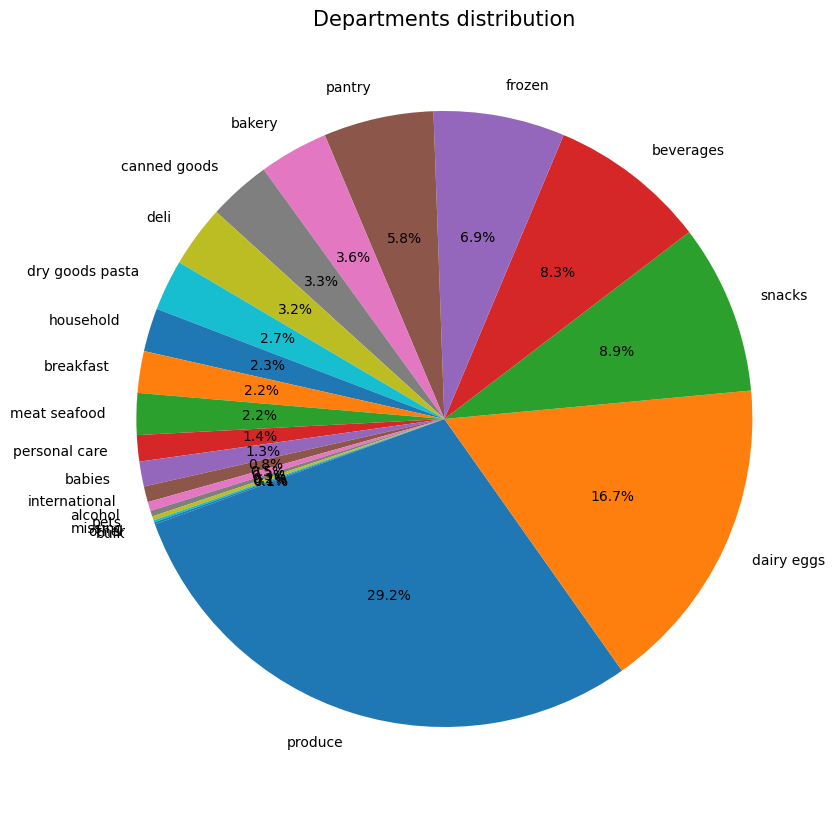

In [67]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index)) # 인덱스를 레이블로 설정
sizes = (np.array((temp_series / temp_series.sum())*100)) # 각각 전체중의 비율로 나타냄
plt.pie(sizes, labels=labels,
        autopct='%1.1f%%', startangle=200)  # 소수점 밑 첫째자리수까지만 표시, 200도에서 부터 그래프 표시시작
plt.title("Departments distribution", fontsize=15)
plt.show()

- Department 별 재주문 비율 알아보기
 - pointplot()
 - 0,1 이산 데이터의 비율은 mean으로도 구할 수 있다

In [72]:
order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean") # 건수 / 총 건수 == 평균으로 비율 계산 가능

,reordered
department,
alcohol,0.569924
babies,0.578971
bakery,0.628141
beverages,0.653460
breakfast,0.560922
bulk,0.577040
canned goods,0.457405
dairy eggs,0.669969
deli,0.607719


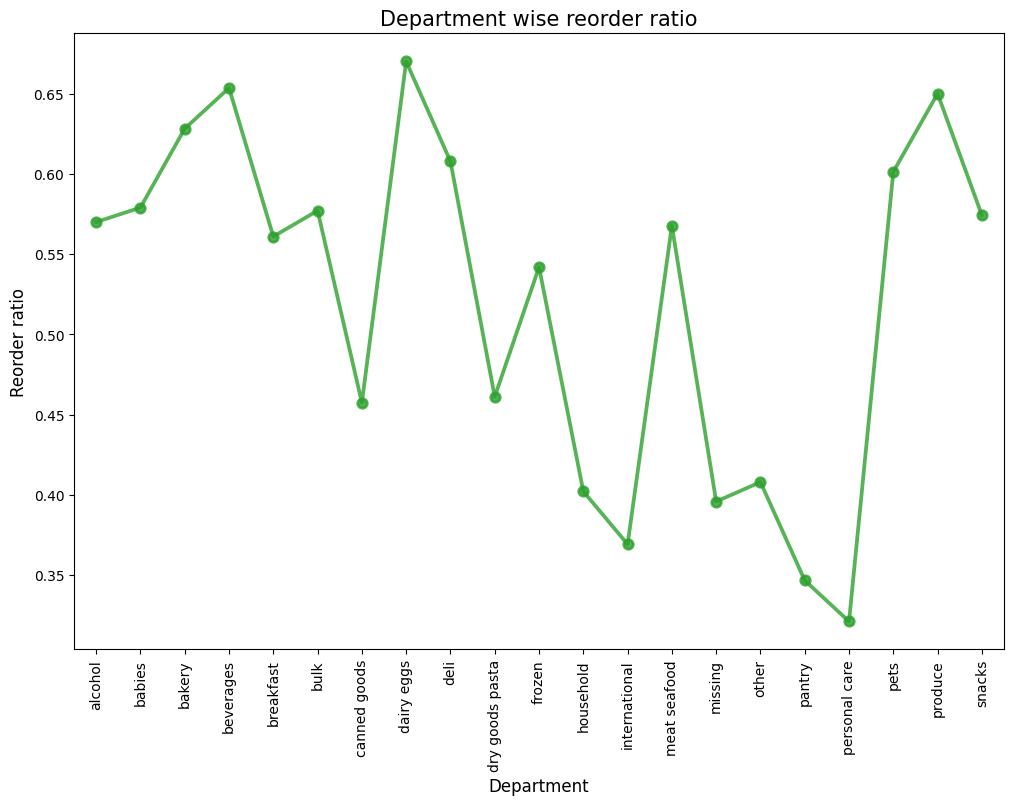

In [68]:
grouped_df=order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['department'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio',fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title('Department wise reorder ratio', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

- 위와 같은 데이터를 파이차트로 시각화 해보기(새로운 시각화)
 - dairy eggs가 가장 재주문 비율이 높음
 - 비율은 무조건 파이차트가 보기 좋을 줄 알았으나, 이렇게 다 비율이 비슷할 때에는 위의 pointplot 같이 y범위가 세분화된 그래프가 더 가독성 있을 수 있다.
 - 비율이 대체적으로 비슷하다는 것은 한눈에 보기 편하다는 장점이 있다.

In [93]:
grouped_df

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922
5,bulk,0.577040
6,canned goods,0.457405
7,dairy eggs,0.669969
8,deli,0.607719
9,dry goods pasta,0.461076


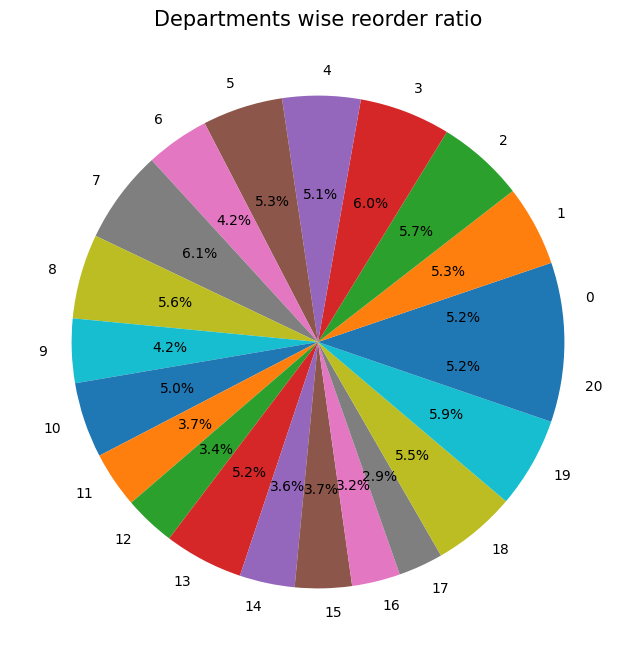

In [92]:
plt.figure(figsize=(8,8))
labels = np.array(grouped_df.index)
plt.pie(grouped_df.reordered, labels=labels,
        autopct='%1.1f%%', startangle=0)  # 소수점 밑 첫째자리수까지만 표시, 200도에서 부터 그래프 표시시작
plt.title("Departments wise reorder ratio", fontsize=15)
plt.show()

- Aisle별 재주문 비율 알아보기
 - 산점도로 좌표를 찍고, 글씨를 넣음
 - 이때 id는 연속형 의미의 변수가 아니므로 두 변수간의 관계 파악은 아닌듯

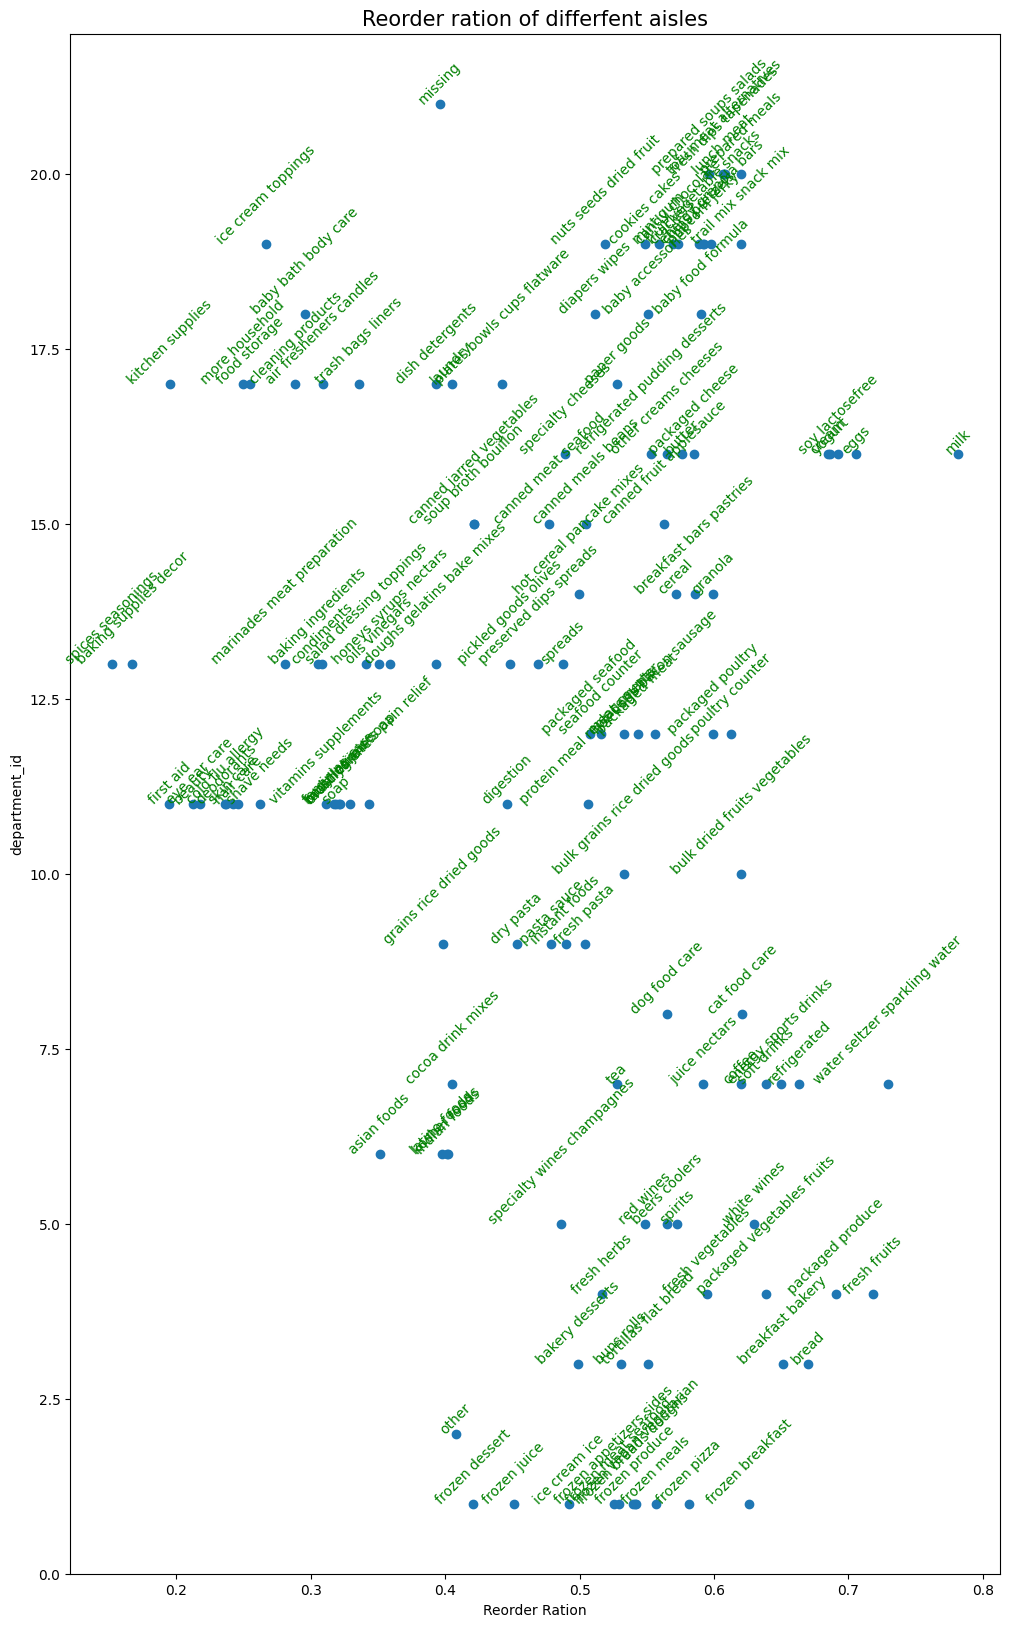

In [94]:
grouped_df=order_products_prior_df.groupby(['department_id','aisle'])['reordered'].aggregate('mean').reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center',color='green')
plt.xlabel('Reorder Ration')
plt.ylabel('department_id')
plt.title('Reorder ration of differfent aisles', fontsize=15)
plt.show()

- 장바구니 추가 순서와 재구매 비율 관계 알아보기
 - 초반에 담은 제품일수록 재구매 비율이 높음. 확실한 상관관계가 있어보임
 - 보통 자주 구매하는 상품을 먼저 담음

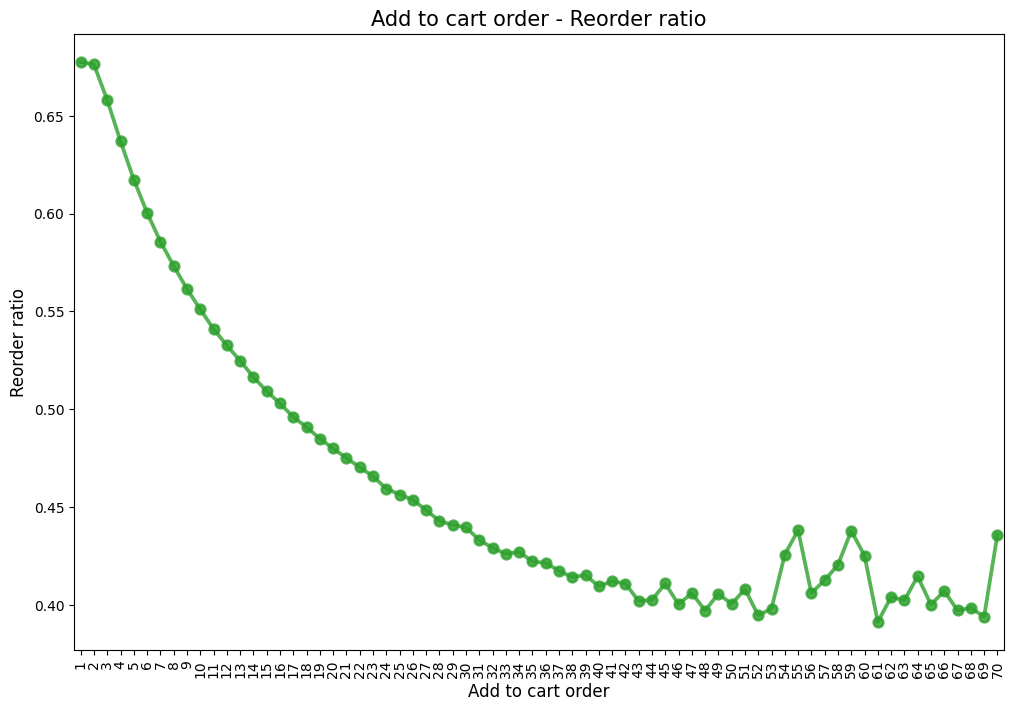

In [105]:
order_products_prior_df['add_to_cart_order_mod']=order_products_prior_df['add_to_cart_order'].copy()
order_products_prior_df['add_to_cart_order_mod'].loc[order_products_prior_df['add_to_cart_order_mod']>70]=70 # 순서 70번 이후는 70으로 설정
grouped_df=order_products_prior_df.groupby(['add_to_cart_order_mod'])['reordered'].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['add_to_cart_order_mod'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio',fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title('Add to cart order - Reorder ratio', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

- 두 변수간의 상관관계 시각화(새로운 시각화)

In [106]:
grouped_df.corr() #높은 음의 상관관계를 보인다.

,add_to_cart_order_mod,reordered
add_to_cart_order_mod,1.000000,-0.841641
reordered,-0.841641,1.000000


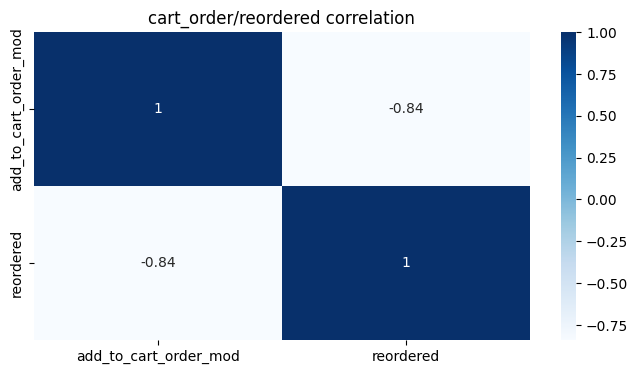

In [100]:
corr2=grouped_df.corr()
plt.figure(figsize=(8,4))
sns.heatmap(corr2, annot=True, cmap='Blues')
plt.title("cart_order/reordered correlation")
plt.show()

In [ ]:
corr_week_hour_interval=orders_df[['order_dow', 'order_hour_of_day', 'days_since_prior_order']].corr()
corr_week_hour_interval
plt.figure(figsize=(8,4))
sns.heatmap(corr_week_hour_interval, annot=True, cmap='Blues')
plt.title("week/hour/interval correlation")
plt.show()

- 시간 변수에 따른 재구매율 알아보기 (요일별, 하루 시간별)

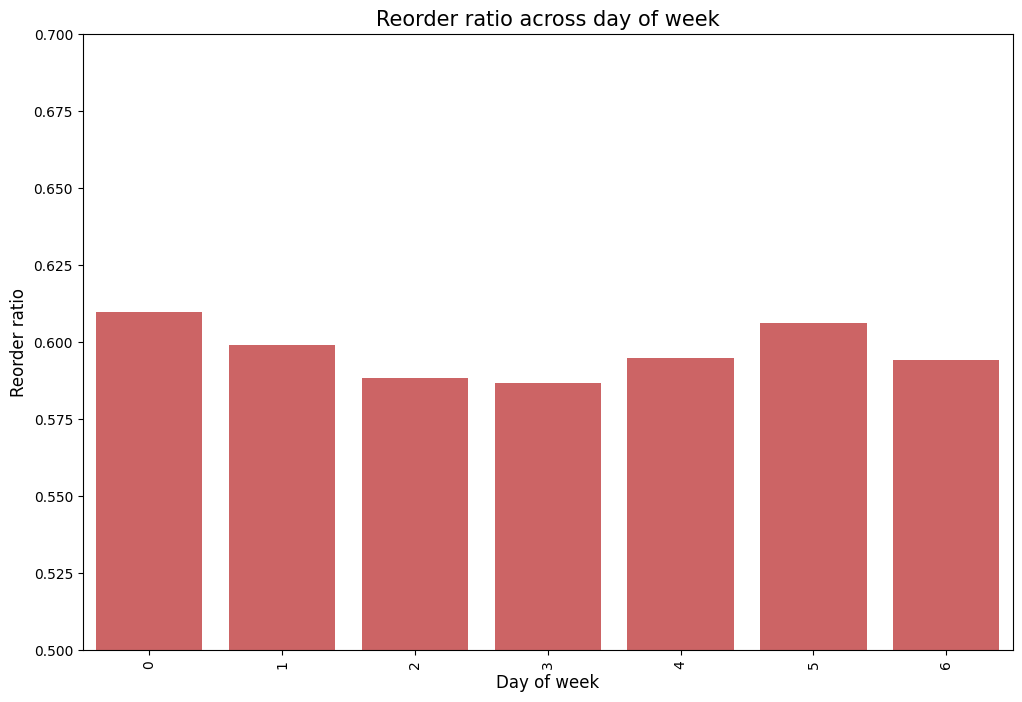

In [101]:
order_products_train_df=pd.merge(order_products_train_df, orders_df,on='order_id', how='left')
grouped_df=order_products_train_df.groupby(['order_dow'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_dow'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title('Reorder ratio across day of week', fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5,0.7)
plt.show()

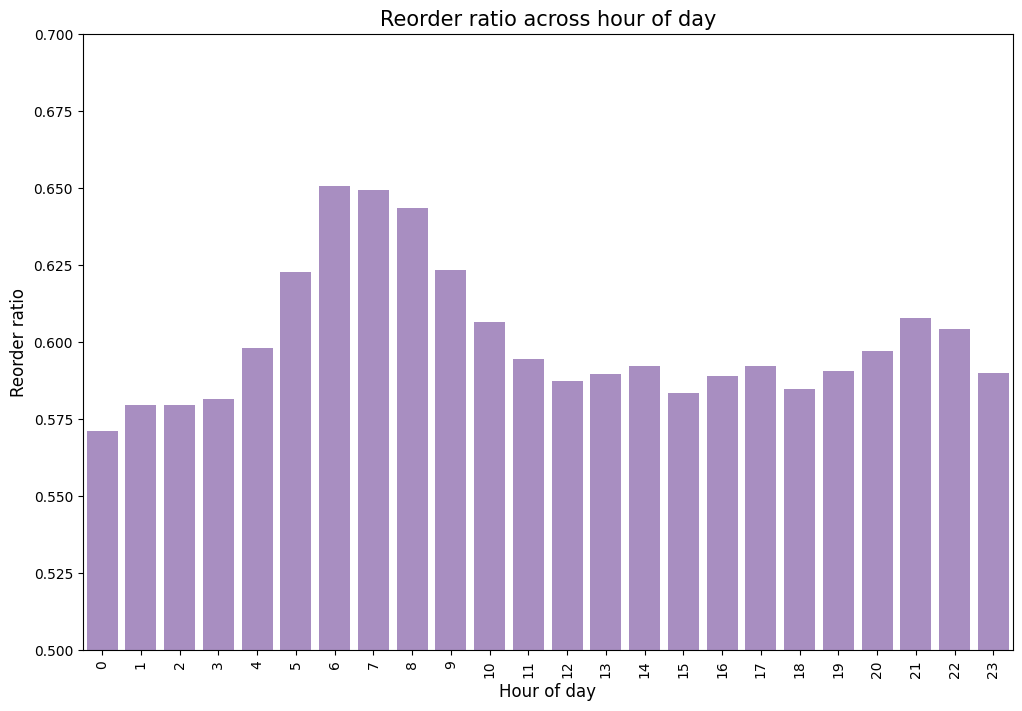

In [103]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_hour_of_day'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

- 요일별, 시간별 재주문율 관계 히트맵 시각화하기
 - 보통 아침에 재주문을 많이 하는 것으로 유추할 수 있음
 - 시간만 보거나 요일만 보는것보다 두 변수를 같이 시각화해 확인하니 더 파악하기 용이함


In [108]:
order_products_train_df.groupby(['order_dow','order_hour_of_day'])['reordered'].aggregate("mean")

order_dow  order_hour_of_day
0          0                    0.577806
           1                    0.587189
           2                    0.593341
           3                    0.553435
           4                    0.599455
                                  ...   
6          19                   0.577114
           20                   0.604114
           21                   0.618027
           22                   0.643312
           23                   0.594640
Name: reordered, Length: 168, dtype: float64

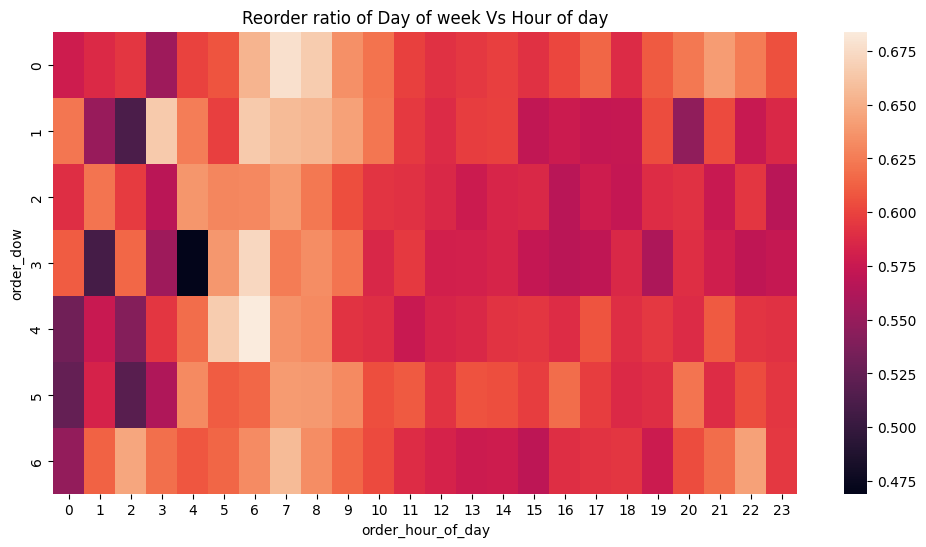

In [110]:
grouped_df=order_products_train_df.groupby(['order_dow','order_hour_of_day'])['reordered'].aggregate("mean").reset_index()
grouped_df=grouped_df.pivot(index='order_dow',columns='order_hour_of_day',values='reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()